<h1 style="text-align: center;font-size:250%">F I X E R  1</h1>

This notebook takes 1D spectra from the red and blue arms reduced with the DRAGONS pipeline, **combines multiple exposures** (if any), **normalizes** the spectra with an automatic continuum fit or a user-defined continuum, **calculates the radial velocity** of the object by performing a cross correlation with a metal-poor template over multiple wavelength ranges, and **radial velocity corrects** the spectrum. Additionally, there is the option to perform a barycentric velocity correction.  

<span style="font-size:150%"> **Inputs:** </span><br>
The 1D spectra (red and blue) from the \_dragons output files. Please note that this fixer should be applied once per observation "epoch". **E.g.: even if there are two observations of a single star in one night, such as S202405040241.fits and S202405040242.fits, they must each be radial velocity corrected separately, and only combined at the very last step.**

If your `[..]_dragons.fits` data comes directly from the **Gemini Archive**, it must first be unzipped and then reduced with dragons. Unzip the tar file with `tar -xvf gemini_data.tar`. 

Then, unzip the individual .bz2 files with `bzip2 -d *.bz2`. 

To finally reduce the .fits files into .dat files, activate DRAGONS in the command line: 

`source ~/.bashrc`

`conda activate` 

`conda activate dragons`

Finally, apply the `reduce -r write1DSpectra [fits filename or *.fits] -p var=True ` command to your data (i.e. the .dat files **must** include variance). For example, all files for your observations are labelled as:   
- S20240504S0241_blue00?_dragons.fits
- S20240504S0241_red00?_dragons.fits
- S20240504S0241_blue00?_dragons_00?.dat
- S20240504S0241_red00?_dragons_00?.dat

Where '?' in red00? indicates the exposure number and '?' in _00?.dat indicates the IFU. *Note: If you have a single-IFU observation, you will have additional _002.dat files, which are the sky files. If your observations come from the dual-IFU mode, the sky files will instead be denoted with _003.dat. They are not needed for any analysis in this notebook.*

Note that the original \_dragons.fits files are only required from this point on if the data has not been barycentric corrected. This is likely only the case for commissioning data..

<span style="font-size:120%"> **File Organization:** </span><br>

To keep files organized, it may be useful to store all your stars data in a folder labeled with the first series of numbers common to all your star's files; i.e S20240504S0241. 

Alternatively, if your star has **multiple epoch observations** (i.e., multiple file names for the same star), it may be more useful to label the directory with the **star id**, and store all of the files in there.

<br />

<span style="font-size:150%"> **Outputs:** </span><br>
By default, this notebook saves its output files in the same folder in which it finds the input files. The labels also resemble the input files in structure in order to easily identify which observation date and number the reduction belong to. The outputs are:
- An .xyz and a .dat file of the combined exposures (1 x blue, 1 x red): 
    - S20240504S0241_00?_blue.xyz / .bin 
    - S20240504S0241_00?_red.xyz / .bin
- An .xyz file of the normalized spectrum (2 x blue, 1 x red):
    - S20240504S0241_00?_blue1_norm.xyz 
    - S20240504S0241_00?_blue2_norm.xyz 
    - S20240504S0241_00?_red_norm.xyz 
- A .txt file with the radial velocities:
    - S20240504S0241_00?_radialVelocities.txt
- An .xyz file with the radial velocity corrected, normalized spectrum (1 x blue, 1 x red):
    - S20240504S0241_00?_blue_normrv.xyz
    - S20240504S0241_00?_red_normrv.xy

where '?' indicates the IFU<br>
This notebook does <u>not</u> combine the blue and the red arms. One technique to combine these arms is described at the end of the notebook.

<span style="background-color: #cdd5c1">  </span>

<span style="font-size:110%"> **Required installations:** </span><br>
The DRAGONS conda package required for 1D spectrum conversion may be found [here](https://github.com/GeminiDRSoftware/DRAGONS).

In [1]:
# Import all necessary modules and packages 
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy import interpolate
from datetime import datetime, date, time, timedelta
import astropy.coordinates as astrocoord
from astropy.time import Time
from astropy.io import fits
from astropy import units as u
import os 
import glob
import itertools
import sys

from apo_tools.spec_tools import Spectrum
from apo_tools.turbospec_tools import SpectrumTS
import apogee.doppler.rv as doppler_rv
import asap_lib.spectra as sa

GEMINI_SOUTH_LOC=astrocoord.EarthLocation.from_geodetic(('-70d44m12.096s'),('-30d14m26.700s'),height=2722.,ellipsoid='WGS84')

In [2]:
# Some necessary functions
class SpecNormRV(Spectrum):
        
    def add_template(self, template):
        self.original_template = template
        self._interpolate_template()
            
    def rv_correct(self, wave_range=None, vel_range=None, inspect=False, 
                   shift_wavelength=True, fill_nan=True, fill_value=1):
        
        if wave_range is None:
            wave_range = [3500, 10600]  
        if vel_range is None:
            vel_range = [-500, 500]
        
        inwave = self.wavelength
        intemp = self.template.flux
        inspec = self.flux
        inerr = np.sqrt(self.variance)

        if fill_nan:
            inspec = np.array(inspec)
            inspec[~np.isfinite(inspec)] = 1
            inerr[~np.isfinite(inspec)] = 1.e6

        wave_mask = (inwave > wave_range[0]) & (inwave < wave_range[1])
        out = doppler_rv.specxcorr(wave=inwave[wave_mask],
                                   tempspec=intemp[wave_mask],
                                   obsspec=inspec[wave_mask], 
                                   obserr=inerr[wave_mask],
                                   plot=inspect,
                                   maxlag=vel_range)
        
        self.rv = out['vrel'][0]
        self.rv_err = out['vrelerr'][0]
        
        if shift_wavelength:
            self.wavelength=self.vel_shift(-1.*self.rv)
            self._interpolate_template()
            
    def barycenter_correction(self, ra, dec, date_obs, utstart, exptime, verbose=False):
        # Set up a SkyCoord for this ad
        sc = astrocoord.SkyCoord(ra, dec,unit=(u.hr, u.deg, ))

        # Compute central time of observation
        dt_start = datetime.combine(
            datetime.strptime(date_obs, '%Y-%m-%d').date(),
            datetime.strptime(utstart, '%H:%M:%S').time(),
        )

        dt_midp = dt_start + timedelta(
            seconds=exptime/2.0
        )
        dt_midp = Time(dt_midp)

        # Vanilla AstroPy Implementation
        corr_fact = sc.radial_velocity_correction('barycentric',obstime=dt_midp,location=GEMINI_SOUTH_LOC)
        corr_fact = corr_fact.to(u.km / u.s)
        self.rv_bary = self.rv + corr_fact.value
            
        if verbose:
            print(f'Correction Factor = {corr_fact:.2f}')
            print(f'RV = {self.rv:.2f}')
            print(f'Barycentric RV = {self.rv_bary:.2f}')
        
    def _interpolate_template(self):
        ip=interpolate.InterpolatedUnivariateSpline(self.original_template.wavelength,self.original_template.flux,k=3,ext=0)
        self.template = Spectrum(self.wavelength,ip(self.wavelength))        

# ----------------------------------------------------         
def comb_blue(blue1, blue2):
    b1w = np.array(blue1['wavelength']) ; b1f = np.array(blue1['flux']) ; b1v = np.array(blue1['variance']) ;
    b2w = np.array(blue2['wavelength']) ; b2f = np.array(blue2['flux']) ; b2v = np.array(blue2['variance']) ;
    wave = np.concatenate([b1w,b2w]) ; flux = np.concatenate([b1f,b2f]) ; varn = np.concatenate([b1v,b2v])
    return wave,flux,varn
    
#-----------------------------------------------------
def comment_out_header(spath):
    with open(spath, 'r') as f:
        lines = f.readlines()
    for i in range(3): # Check if the column names are in the top 3 lines, and comment them out.
        line = lines[i]
        if ('#' not in line) and ('wavelength data variance' in line):
            os.system(f"sed -i '{i+1}s/wavelength data variance/# wavelength data variance/' {spath}")
            
        elif ('#' not in line) and ('wavelength flux variance' in line):
            os.system(f"sed -i '{i+1}s/wavelength flux variance/# wavelength flux variance/' {spath}")

In [3]:
## These are extra wavelength regions to see how the
#  RV corrections vary across the spectrum.
#  Feel free to update!!

wavelengths_dict = {
    'blue1':   [4000, 4400], 
    'blue2':   [4400, 4800],
    'blue3':   [4800, 5300],
    'blue12':  [4000, 4800],
    'blue23':  [4400, 5300],
    'blue123': [4000, 5300], 
    
    'red1':    [5300, 5800],
    'red2':    [6000, 6500],
    'red3':    [6600, 7500],
    'red12':   [5300, 6500],
    'red23':   [6000, 7500],
    'red123':  [5300, 7500],
}

# Corrections made around specific lines
wavelengths_lines_dict = {
    'blue_CaHK': [3800, 4000],
    'blue_Hd':   [4000, 4200],
    'blue_Hg':   [4200, 4400],
    'blue_Hb':   [4700, 4900],
    'blue_MgB':  [5100, 5300],
     
    'red_NaD':   [5800, 6000],
    'red_Ha':    [6500, 6700],
    'red_CaT':   [8400, 8700],
    'red_CaT2':  [8525, 8575]
}

def correct_RV_at_wrange(wrange, bary=False, bfull=False):
    """
    For the latter half of this notebook: Correct for the radial velocity,
    at a specified wavelength range.
    
    Note: There are a few GLOBAL variables in this notebook. Please
    be careful if changing any variable names.
    """
    if max(wrange) <= 5300: # Aka: if wrange spans the blue arm
        if min(wrange) >= 4400:
            spectrum = cand_blue2
        elif max(wrange) <= 4400:
            spectrum = cand_blue1
        else:
            spectrum = cand_blue
    else:
        spectrum = cand_red
    
    if bfull == True:
        spectrum = cand_blue

    spectrum.rv_correct(wave_range=wrange,  inspect = False, shift_wavelength=False)
    
    if bary == True:
        if max(wrange) <= 5300:
            spectrum.barycenter_correction(*blue_bary_data)
        else:
            spectrum.barycenter_correction(*red_bary_data)
        return spectrum.rv_bary, spectrum.rv_err
    
    return spectrum.rv, spectrum.rv_err

def correct_regions(specific_lines=False, bary=False):
    correction_dict = wavelengths_dict
    if specific_lines == True:
        correction_dict = wavelengths_lines_dict
    
    for key in correction_dict.keys():
        wrange = correction_dict[key]
          
        rv, rv_err = correct_RV_at_wrange(wrange, bary)
        
        print(f'RV correction: {key.ljust(10)} \t {wrange}: \t {rv} \t± {rv_err}')

    print('\n')
    return None

def save_RV(lines, bary=False):
    # lines is a list of wavelength 'keys', 
    #  e.g. lines = ['blue123', 'red_Ha']
    if not isinstance(lines, list):
        raise ValueError(f'Input should be a list of key(s)')
    
    full_dict = wavelengths_dict.copy()
    full_dict.update(wavelengths_lines_dict)
    
    output = ""
    
    for line in lines:
        if 'range' in line:
            bfull = False
            wrange = formal_corrections[line]
            if line == 'blue_range':
                bfull = True
            
            rv, rv_err = correct_RV_at_wrange(wrange, bary, bfull)

        elif line.strip() not in full_dict.keys():
            raise ValueError(f'Please specify valid lines to save, {line.strip()} is not a valid region.')
        else:
            wrange = full_dict[line.strip()]
            rv, rv_err = correct_RV_at_wrange(wrange, bary)
            
        output += f'{line[0].capitalize() + line[1:]}:'.ljust(15) + f'\t{rv} \t± {rv_err}\n'
    
    output += '\n'
    return output

# Indicate file path
<span style="text-align:left; background-color: #cdd5c1"> This cell requires user input</span><br>
This cell allows the rest of the notebook to find/save files. Indicate the observation number (that which includes the date) under `star`, the IFU (usually \_001 or \_002) in `num`, the path to the FIXER_1 folder in your directories in `path`, and the path to the folder containing your star/observation's data *within* the FIXER_1 folder in `fipath`.

The paths and file names are broken down in this manner because each component is used separately somewhere in the notebook. 

In [4]:
# Indicate the object and confirm file path.

star = 'S20240902S0007' # Gemini Filename
num  = '_002' # IFU
end  = '_dragons' + num  

path =  f'/astro/adovgal/SCRIPTS/GHOULS_FIXER_v3/' # Points to /FIXER_1.
fipath = path  + f'TEST_DATA/Aqu2_776_B/' # This is the same path where output files will be saved,
                                          #   and where data is stored
spath  = fipath + star  

In [5]:
spath

'/astro/adovgal/SCRIPTS/GHOULS_FIXER_v3/TEST_DATA/Aqu2_776_B/S20240902S0007'

## NOTE: If you only want to run RV corrections, RUN UP TO THIS POINT and continue at "Calculate and Correct for Radial Velocity"

# Combine Exposures
The following cell combines multiple exposures (if any) of each arm for the indicated IFU in `num` and saves the stack as both .bin and .xyz files. This cell must be run even if there is only one exposure per arm. 

This cell will indicate whether the notebook was able to **find** and **save** your exposures. If not, adjust the cell above so it can. 
<br>If an ERROR message appears indicating the first line of the .dat file can't be read, go into the file and comment out the line `wavelength flux variance`, but **don't delete it**; have it be: `# wavelength flux variance`. This should be done by the script automatically, but this message remains just in case.

In [6]:
for camera in ['blue', 'red']:
    
    naming = '*{}*'+ end + '.dat'
    condition = naming.format(camera)
    obs = glob.glob(spath+condition)
    
    print('Found {} exposure(s) to combine: '.format(len(obs)))
    print( * obs, sep = "\n")

    # --------------------------------
    waves  = []
    fluxes = []
    varian = []

    for item in obs:
        comment_out_header(item) # Comments out the wavelength data variance header automatically.
        wave, flux, var = sa.read_spec(item, ftype ='xyz')

        waves.append(wave)
        fluxes.append(flux)
        varian.append(var)
    
    # --------------------------------
    pairs =  list(itertools.combinations(range(len(waves)), 2))

    value = True
    for pair in pairs:
        value = np.array_equal(waves[pair[0]], waves[pair[1]])
        if value == False:
            print('Wavelength arrays not equivalent. Do not proceed')
            break
    
    if value == False:
        break

    if len(waves) > 0:
        # -------------------------------- Median Combine flux and combine error with Poisson statistics 
        finalWave = waves[0]
        finalFlux = np.median(fluxes,axis = 0)
        #finalErr = np.zeros(len(finalWave))
        finalErr = np.sqrt( sum(i*i for i in varian) ) / len(waves)

        # -------------------------------- Save the output as .xyz and .bin files 
        sa.write2xyz(finalWave, finalFlux, finalErr, spath +num+'_{}'.format(camera))
        sa.write2bin(finalWave, finalFlux, finalErr, spath +num+'_{}'.format(camera))

        print('Saved combination of {} {} camera image(s)'.format(len(waves), camera))
        # --------------------------------

    else:
        print('No {} camera files found'.format(camera))


Found 1 exposure(s) to combine: 
/astro/adovgal/SCRIPTS/GHOULS_FIXER_v3/TEST_DATA/Aqu2_776_B/S20240902S0007_blue001_dragons_002.dat
Saved combination of 1 blue camera image(s)
Found 1 exposure(s) to combine: 
/astro/adovgal/SCRIPTS/GHOULS_FIXER_v3/TEST_DATA/Aqu2_776_B/S20240902S0007_red001_dragons_002.dat
Saved combination of 1 red camera image(s)


<br>

### Patch NaN and Inf values   (OPTIONAL)
Sometimes spectra have nan and inf values which can be difficult to work with. The following code will change all inf and nan flux values in a spectrum to a specified value (This can be performed at any stage ). <br>
This cell is "turned off" by default but included just in case the user needs it.

<br>

__________

# Normalization
<span style="background-color: #cdd5c1"> This routine requires user input </span><br>
This section performs the normalization of the spectra. In order to achieve a better continuum estimation, the blue arm is split in two sections: blue1 spans the wavelength region [3700, 4405] Å while blue2 spans the region [4395, 5305] Å. The two sections of the blue arm are re-combined later.  


The following cell reads each of the files separately, this means **you will run the routine at least three times** (making sure to save your favourite fits) in order to obtain a normalized red arm, a normalized blue1 section and a normalized blue2 section (i.e. there needs to be three output files). 

In [15]:
# Indicate the camera and number(if applicable)

camera = 'red'             # options are:'red' or 'blue'
nblue  = '2'               # if blue, options are: '1' or '2' 
ftyp   = 'bin'             # type of file we want to read 

# -------------------------------------------------------------------------------

fpath  = spath + f'{num}_{camera}.{ftyp}'  # Path to combined-exposures files

# Read the files
w, f, e = sa.read_spec(fpath, ftype = ftyp)

# This selection crops off noisy ends and splits the blue spectra
if camera == 'red':
    w_min = 5295
    w_max = 9500
    colour = 'tab:orange'
    contr  = 'tab:blue'

elif camera == 'blue':
    if nblue == '1':
        w_min  = 3700     
        w_max  = 4405    
        colour = 'royalblue'
        contr  = 'tab:orange'
        
    elif nblue == '2':
        w_min  = 4395
        w_max  = 5305
        colour = 'tab:blue'
        contr  = 'tab:orange'

ind = np.where( (w >= w_min) & (w <= w_max ) )[0]

wave = w[ind]
flux = np.array(f[ind].flatten(), dtype='float32')
error = np.array(e[ind].flatten(), dtype='float32')

print("File being read:\n",fpath)

File being read:
 /astro/adovgal/SCRIPTS/GHOULS_FIXER_v3/TEST_DATA/Aqu2_776_B/S20240902S0007_002_red.bin


###  Auto Continuum normalization:
Use the plots to visualize the continuum fit. **Adjust the smooth_kernel to change the shape of the continuum in the second plot and change the sigma variables** to move the fit up or down on the last plot. Works best for `red` and `blue2`.

In [16]:
# Indicate values for the following parameters and run the cell to perform the normalization

if camera == 'red':
    smooth_kernel = 2000   
    sigma_lower = 1.5     
    sigma_upper = 3       

if camera == 'blue':
    if nblue == '2':
        smooth_kernel = 900    
        sigma_lower = 1.5 # 1.1 
        sigma_upper = 3       
    
    elif nblue == '1': 
        smooth_kernel = 400    
        sigma_lower = 1.5       
        sigma_upper = 3    

norm, cont = sa.contnorm_filter(flux, smooth_kernel, mode='reflect')
norm2 = sa.contnorm_sigclip(norm, sigma_lower, sigma_upper)

<IPython.core.display.Javascript object>


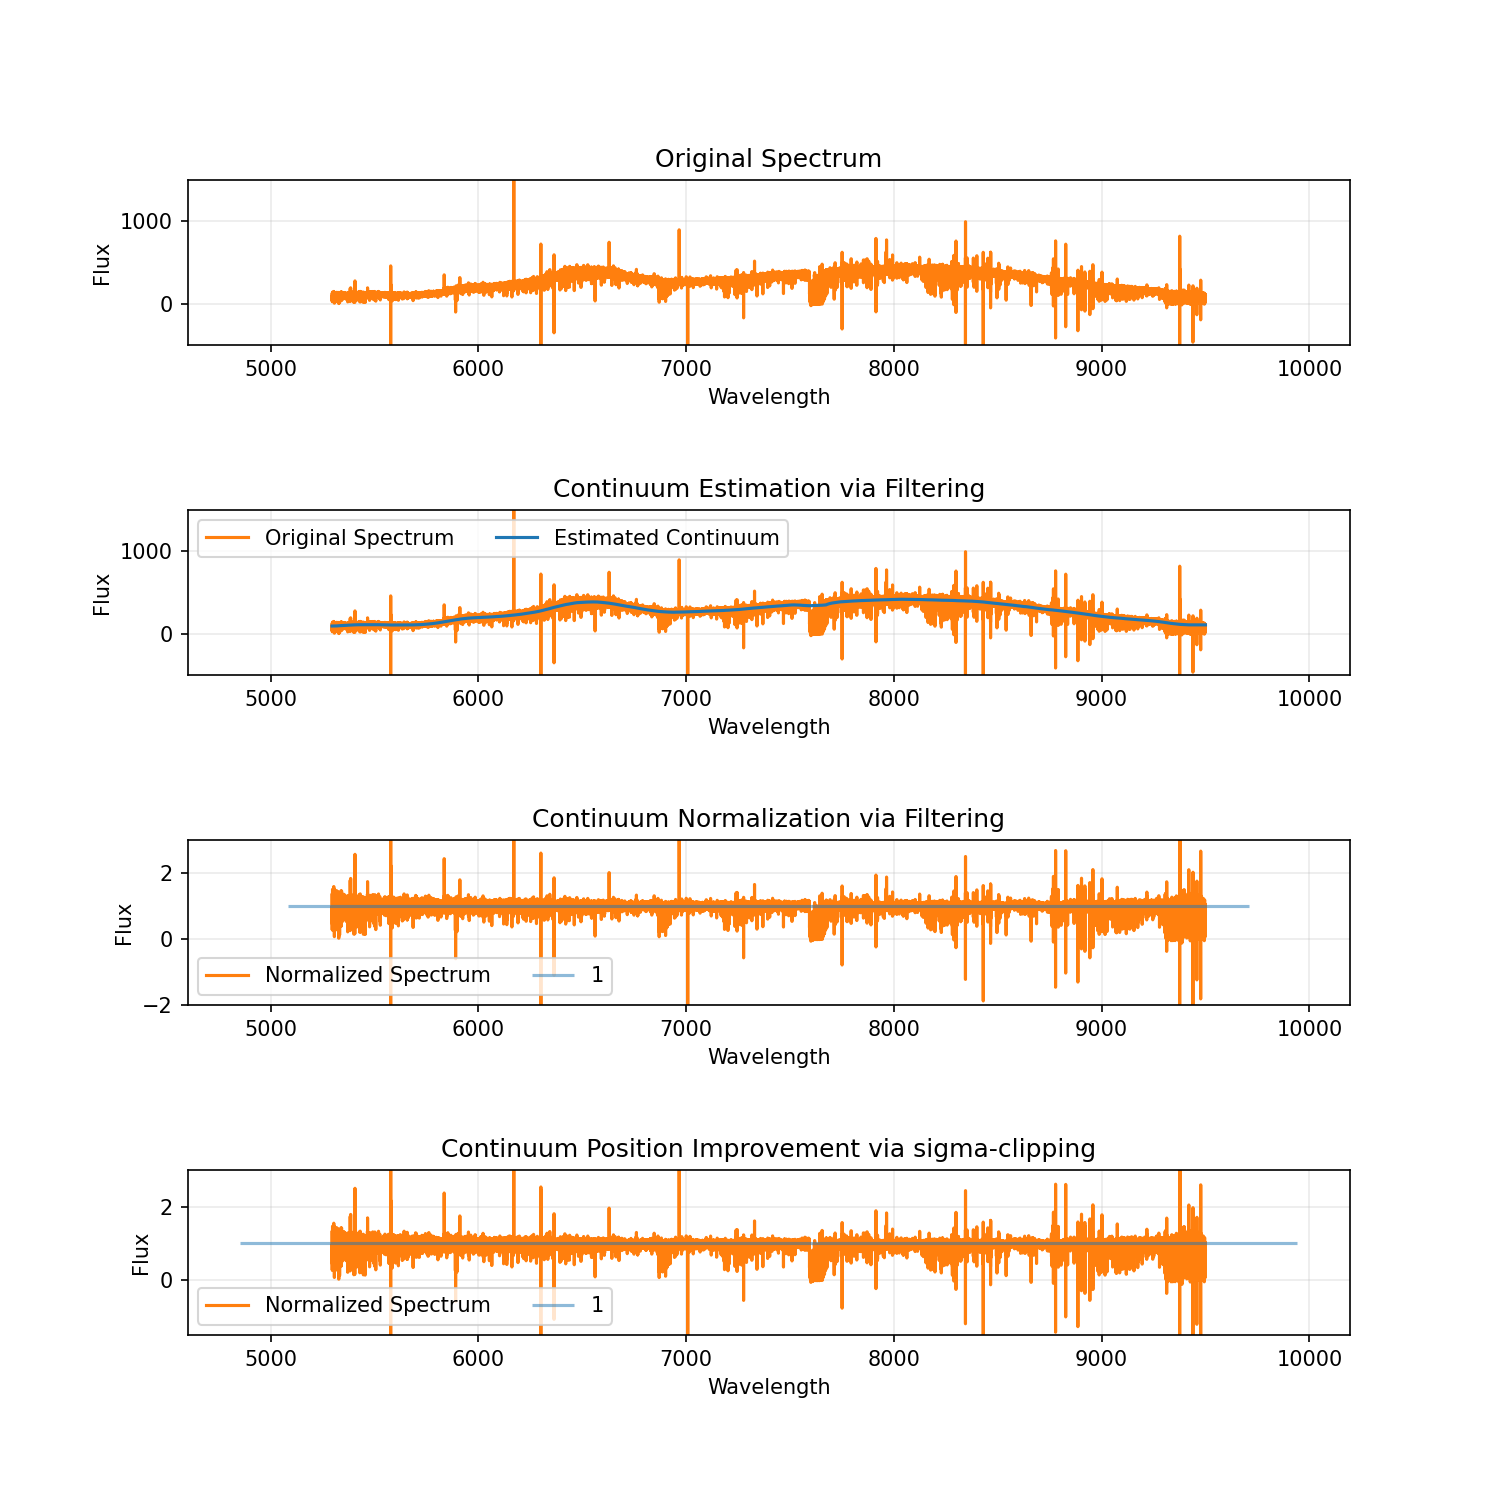

In [17]:
# These plots are to visualize the normalization
%matplotlib notebook
plt.figure(figsize=(10,10))

#-------------------
ax = plt.subplot( 411 )
plt.title('Original Spectrum')
plt.plot( wave, flux , color = colour)
plt.grid(alpha=0.25)
plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.ylim(-500,1500)

#-------------------
ax2 = plt.subplot( 412, sharex=ax )
plt.title('Continuum Estimation via Filtering')

plt.plot( wave, flux, label='Original Spectrum', color=colour)
plt.plot( wave, cont, label='Estimated Continuum', color=contr)
plt.grid(alpha=0.25)
plt.legend(ncol=2)
plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.ylim(-500,1500)

#-------------------
ax3 = plt.subplot( 413, sharex=ax )
plt.title('Continuum Normalization via Filtering')

plt.ylim(-2,3)

plt.plot( wave, norm, label='Normalized Spectrum', color = colour)
plt.grid(alpha=0.25)
xmin, xmax = ax.get_xlim()
plt.hlines(1,xmin,xmax, color=contr,zorder=5,alpha=0.5, label='1')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend(ncol=2)

#-------------------
ax4 = plt.subplot( 414, sharex=ax )
plt.title('Continuum Position Improvement via sigma-clipping')

plt.plot( wave, norm2, label='Normalized Spectrum', color = colour)
plt.grid(alpha=0.25)
xmin, xmax = ax.get_xlim()
plt.hlines(1,xmin,xmax, color=contr,zorder=5,alpha=0.5, label='1')
plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.ylim(-1.5,3)

#-------------------
plt.legend(ncol=2)
plt.subplots_adjust(hspace=1)

**OPTIONAL:** Save the result
<br> Once you are satisfied with the auto-normalization, save the spectrum by running the following cell. 

In [18]:
if camera == 'blue':
    section = nblue
else:
    section = ''
save_path = f'{fipath}{star}{num}_{camera}{section}_norm'

print(len(error), len(wave), len(norm2))
sa.write2xyz(wave, norm2, error, save_path)

55307 55307 55307


### <span style="color: red"> ITERATE THE ABOVE 4 CELLS UNTIL ALL THREE REGIONS ARE CONTINUUM NORMALIZED </span>

# (OPTIONAL) Manual Continuum Normalization, e.g. for CH 4320 band:

In [24]:
lines = open(path + 'norm/metal_poor_template.spec.convol').readlines()

turbo_w = [ float(line.split()[0]) for line in lines ]
turbo_f = [ float(line.split()[1]) for line in lines ]

In [26]:
continuum.Help()

- Left click on the original spectrum (upper plot) to place points along the continuum 
- Right click on the original spectrum (upper plot) to delete continuum points 
- Continuum points cannot be placed when a toolbar item is active 
- Hit h to return to the original view 
- Hit r to clear all points 
- Hit enter to create the continuum and normalize with it 


<IPython.core.display.Javascript object>


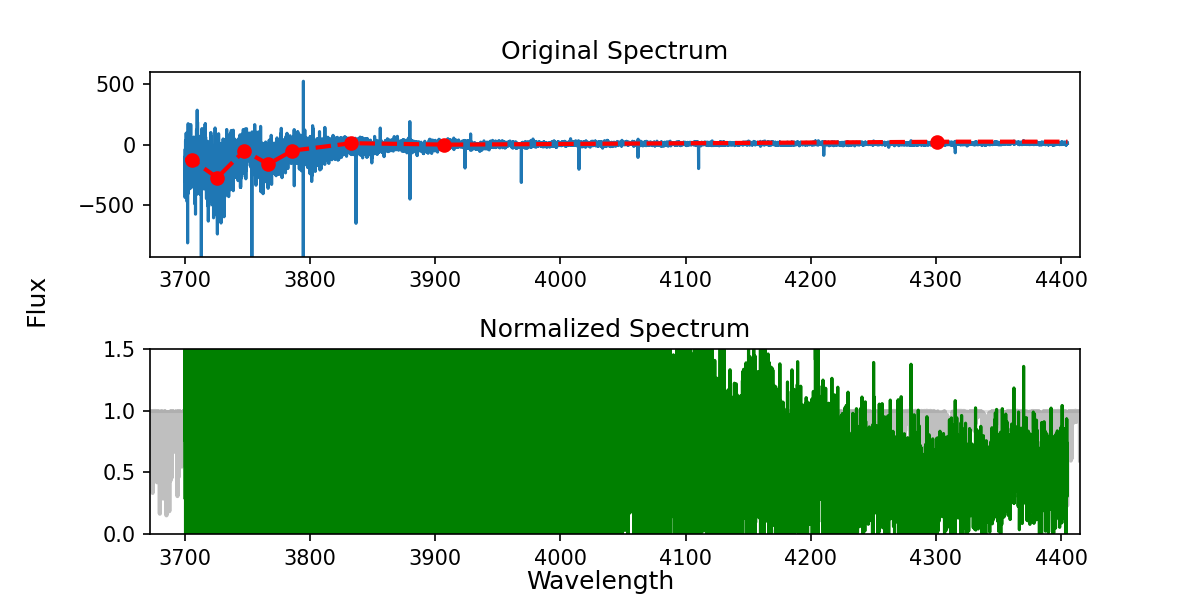

In [25]:
# ---------- Initialize and create continuum
%matplotlib notebook
continuum = sa.drawContinuum(wave, flux)
continuum.addReference(turbo_w, turbo_f)
continuum.connect()

In [27]:
continuum.disconnect()

In [28]:
if camera == 'blue':
    section = nblue
else:
    section = ''
save_path = f'{fipath}{star}{num}_{camera}{section}_norm_manual'

sa.write2xyz(wave, continuum.norm, error, save_path)

<br>Once you have saved your preferred normalization, **go back to the top of this routine and normalize the other sections** of your spectrum. You should have one _norm.xyz file for the red arm and two for the blue arm (blue1, blue 2).

---
# Calculate  and correct for Radial Velocity 
The following cells will open the files saved from the Normalization routine, and carry their modifications forward without saving them as files. This is why re-running any of the radial velocity correction cells more than once before restarting the kernel or switching input files will give near-zero radial velocities (the routine will radial-velocity correct spectra that has already been radial-velocity corrected!). 

The first cell in this routine indicates the saved files names and assigns the names of the output files. 
The second cell reads them out (the blue arm is stitched back together) and stores the three columns as a variable that can be modified using the SpecNormRV functions defined in the second cell of this notebook.
The third cell plots the normalized red and blue arms found in the saved files. 

In [ ]:
## UNCOMMENT IF YOU HAVE ALREADY CONTINUUM NORMALIZED DATA
# Indicate the object and confirm file path.

# Sag2_440_F: S20250401S0135, S20250423S0124, S20250423S0125

# star = 'S20250130S0041' # 125, 126, 127
# num  = '_001' # IFU
# end  = '_dragons' + num  

# path =  f'/astro/adovgal/GHOULS_DATA/' # Points to /FIXER_1
# fipath = path  + f'Car2_208_A/' # This is the same path where output files will be saved
# spath  = fipath + star                               

In [20]:
# Naming of Files 

ftyp = 'xyz'
blue1_spec_filename = spath + f'{num}_blue1_norm.{ftyp}' 
blue2_spec_filename = spath + f'{num}_blue2_norm.{ftyp}'
blue_spec_filename  = spath + f'{num}_blue_norm'   
red_spec_filename   = spath + f'{num}_red_norm.{ftyp}'    
template_filename   = path  + 'norm/metal_poor_template.spec.convol'
rvnorm_blue         = spath + f'{num}_blue_normrv'
rvnorm_red          = spath + f'{num}_red_normrv'
radial_velocities   = spath + f'{num}_radialVelocities.txt'

In [21]:
# Read in the xyz files
data_blue1 = np.genfromtxt(blue1_spec_filename, dtype = None, encoding = None, names = True)
data_blue2 = np.genfromtxt(blue2_spec_filename, dtype = None, encoding = None, names = True)
data_red   = np.genfromtxt(red_spec_filename,   dtype = None, encoding = None, names = True) 

data_blue1['variance'][data_blue1['variance']== 0.] = 1.e6
data_blue2['variance'][data_blue2['variance']== 0.] = 1.e6
data_red['variance'][data_red['variance'] == 0.]  = 1.e6

data_blue1['flux'][~np.isfinite(data_blue1['flux'])]= 0.0
data_blue2['flux'][~np.isfinite(data_blue2['flux'])]= 0.0
data_red['flux'][~np.isfinite(data_red['flux'])]  = 0.0

data_blue1['variance'][~np.isfinite(data_blue1['variance'])] = 1.e6
data_blue2['variance'][~np.isfinite(data_blue2['variance'])] = 1.e6
data_red['variance'][~np.isfinite(data_red['variance'])]   = 1.e6

# Recobine the blue arm 
W,F,V = comb_blue(data_blue1, data_blue2)
sa.write2xyz(W,F,V,blue_spec_filename)
data_blue = np.genfromtxt(blue_spec_filename+'.xyz',dtype = None, encoding = None, names = True)

# Feed to spectra to SpecNormRV function
cand_blue1 = SpecNormRV(data_blue1['wavelength'], data_blue1['flux'], variance = data_blue1['variance'])
cand_blue2 = SpecNormRV(data_blue2['wavelength'], data_blue2['flux'], variance = data_blue2['variance'])
cand_red   = SpecNormRV(data_red['wavelength'],   data_red['flux'],   variance = data_red['variance'])
cand_blue  = SpecNormRV(data_blue['wavelength'],  data_blue['flux'],  variance = data_blue['variance'])

template = SpectrumTS(template_filename)

<IPython.core.display.Javascript object>


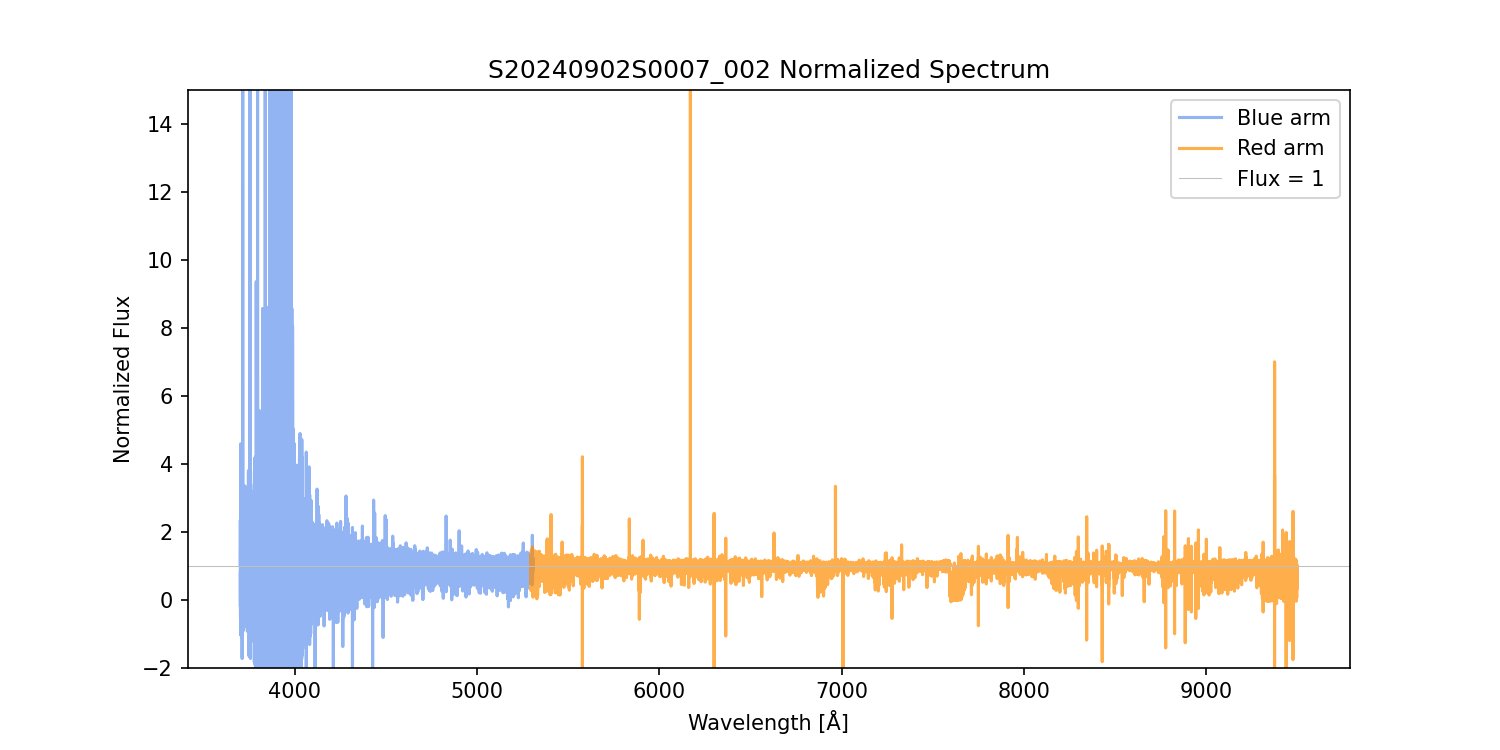

In [22]:
# Plot both arms 
%matplotlib notebook 
x = np.linspace(3500,9100,len(cand_red.wavelength))
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax.set_ylim(-2,15)
ax.set_title(f'{star}{num} Normalized Spectrum')
ax.set_ylabel('Normalized Flux')
ax.set_xlabel('Wavelength [Å]')

ax.plot(cand_blue.wavelength,cand_blue.flux, c='cornflowerblue', alpha= 0.7,label='Blue arm')
ax.plot(cand_red.wavelength, cand_red.flux,  c='darkorange',alpha= 0.7, label='Red arm')

ax.axhline(1, c='silver', linewidth=0.5, label='Flux = 1')
ax.legend()

## Calculate RV from cross-correlation
This step uses the metal poor template in "norm" to cross correlate with the input spectra over selected wavelength ranges. This cell uses 3 diferent ranges to estimate the star's radial velocity: 
- cand_blue1 spans the bluest region of the blue without including the noisy end
- cand_blue2 spans from the end of blue1 to the red-most end
- cand_blue is the region including both blue1 and blue2 (used for the spectrum rv correction, but not calculation)
- cand_red2 is the bluest region of the red arm (used for rv correction)

The velocity obtained for each region and its **fitting** errors are printed (in km/s)



Re-run this cell with different ranges if needed.

In [23]:
# Add the metal poor template 
cand_blue1.add_template(template) ; cand_blue2.add_template(template) ;
cand_blue.add_template(template) ; cand_red.add_template(template) ;

# =========================================================
## Extra checks to see which regions fail with RV corrections:

# Print out corrections for subregions and superregions
RV_correct_many_regions = True
# Print out corrections for specific lines
RV_correct_many_lines   = True

if RV_correct_many_regions == True:
    correct_regions()
    
if RV_correct_many_lines == True:
    correct_regions(specific_lines=True)
    
# =========================================================

print("Corrections used for the final RV calculation:")

# The final corrections should all be close to each other.
#  If not, adjust ranges until they are all similar.

# Right now, the wavelength regimes correspond to blue1, blue23, red12, and blue123.
# Normally you will NOT have to change these.
formal_corrections = {
    'blue_range1':[4000, 4400], # Must be within [4000,4400]  DEFAULT: [4000,4400]
    'blue_range2':[4400, 5300], # Must be within [4400,5300]  DEFAULT: [4400,5300]
    'red_range'  :[5300, 6500], # Must be within [5300,9000]  DEFAULT: [5300,6500]
    'blue_range' :[4000, 5300]  # Must be within [4000,5300]  DEFAULT: [4000,5300]
}


print('blue1:  \t{}\t± {}'.format(*correct_RV_at_wrange(formal_corrections['blue_range1'])))
print('blue23: \t{}\t± {}'.format(*correct_RV_at_wrange(formal_corrections['blue_range2'])))
print('red12:  \t{}\t± {}'.format(*correct_RV_at_wrange(formal_corrections['red_range'])))

print("\nNot included for final RV calculation, but displays the RV correction applied to the blue arm for the output spectrum.")
print('blue123:\t{}\t± {}'.format(*correct_RV_at_wrange(formal_corrections['blue_range'], bfull=True)))

RV correction: blue1      	 [4000, 4400]: 	 -66.08890984528135 	± 0.03239652627394424
RV correction: blue2      	 [4400, 4800]: 	 -65.45075364643289 	± 0.007807178082881207
RV correction: blue3      	 [4800, 5300]: 	 -65.68349574320803 	± 0.01617608547484488
RV correction: blue12     	 [4000, 4800]: 	 -65.93790103430774 	± 0.03266014736011832
RV correction: blue23     	 [4400, 5300]: 	 -65.56650912618124 	± 0.011682178320663662
RV correction: blue123    	 [4000, 5300]: 	 -65.87185610507571 	± 0.03266753766691374
RV correction: red1       	 [5300, 5800]: 	 -66.02372091248836 	± 0.05791382067388629
RV correction: red2       	 [6000, 6500]: 	 -66.08013124655885 	± 0.0217127304678612
RV correction: red3       	 [6600, 7500]: 	 -65.55415858509912 	± 0.058982889929291904
RV correction: red12      	 [5300, 6500]: 	 -66.02312930518072 	± 0.05240586586117455
RV correction: red23      	 [6000, 7500]: 	 -65.95699602603361 	± 0.03254386476294102
RV correction: red123     	 [5300, 7500]: 	 -65.9915

In [24]:
# These are the regions whose RV corrections will be saved to the radialVelocities.txt file
lines_to_save = ['blue_range1', 'blue_range2', 'blue_range', 'red_range',
                 'red_Ha', 'blue_MgB']

In [25]:
print(save_RV(lines_to_save))

Blue_range1:   	-66.08890984528135 	± 0.03239652627394424
Blue_range2:   	-65.56650912618124 	± 0.011682178320663662
Blue_range:    	-65.87185610507571 	± 0.03266753766691374
Red_range:     	-66.02312930518072 	± 0.05240586586117455
Red_Ha:        	-66.48362265211668 	± 0.32447368767489077
Blue_MgB:      	-65.6280601940543 	± 0.021115984561355786




## Barycentric correction (OPTIONAL)
The DRAGONS pipeline automatically does a barycentric correction which is why these cells are not used as code by default. However, for some of the commissioning files, DRAGONS is not able to perform the correction. If that is the case for your files, change the format of the following cell to code (from RAW) and use `True` in the save cell below it. 

### Save the radial velocities and their mean in a file for your reference. 
The following cell saves the radial velocities obtained for each of the wavelength ranges as well as a mean (printed) of the trusted ranges (typically blue1, blue2, red2) and corresponding uncertainties in a text file. **Note that the final uncertainty in radial velocity does not take into account the fitting uncertainties, due to assumptions made in uncertainty derivations. Instead, the final uncertainty is the standard deviation between the radial velocities of each of the three regions. However, the propagated error may be turned on with `include_quad_err = True`.** The cell also saves the radial-velocity corrected red and blue spectra for the IFU in .xyz files.  

In [26]:
# Final RV corrected spectra:
save_red = SpecNormRV(data_red['wavelength'],   data_red['flux'],   variance = data_red['variance'])
save_blue = SpecNormRV(data_blue['wavelength'],  data_blue['flux'],  variance = data_blue['variance'])
save_red.add_template(template) ; save_blue.add_template(template) ;
save_red.rv_correct(wave_range=formal_corrections["red_range"],  inspect = False, shift_wavelength=True)
save_blue.rv_correct(wave_range=formal_corrections["blue_range"], inspect = False, shift_wavelength=True)

# Turn on barycentric velocity correction if required (TRUE vs FALSE). Off by default
barycentric_velocity_correction = False 

# -----------------------------------------
if barycentric_velocity_correction == True:
    rv_blue1, rv_blue1_e = correct_RV_at_wrange(formal_corrections["blue_range1"], bary=True)
    rv_blue2, rv_blue2_e = correct_RV_at_wrange(formal_corrections["blue_range2"], bary=True)
    rv_red,   rv_red_e   = correct_RV_at_wrange(formal_corrections["red_range"], bary=True) 
else: 
    rv_blue1, rv_blue1_e = correct_RV_at_wrange(formal_corrections["blue_range1"])
    rv_blue2, rv_blue2_e = correct_RV_at_wrange(formal_corrections["blue_range2"])
    rv_red,   rv_red_e   = correct_RV_at_wrange(formal_corrections["red_range"])
# -----------------------------------------

# Indicate which radial_velocities you trust and their corresponding errors.
rvs = [rv_blue1,rv_blue2,rv_red]
rve = [rv_blue1_e,rv_blue2_e,rv_red_e]

# -----------------------------------------
mean_rv = sum(rvs)/len(rvs)
rv_err  = np.std(rvs)

rv_quad_err = np.sqrt(np.sum(np.array(rve)**2))
include_quad_err = True

# Formating and writing to the Text file 
Des = "Radial velocities in km/s. Estimated by crosscorrelating sections of the spectrum with a metal poor template\n\n"

Top = save_RV(lines_to_save, barycentric_velocity_correction)

Res = f'Mean RV:\t{mean_rv}\t± {rv_err}\n'
if include_quad_err == True:
    Res += f'Error from sum in quadrature is:\t± {rv_quad_err}\n'
Res += f'Computed with:{rvs}'

# #================================================================================
with open(radial_velocities,"w") as rv_results:
    rv_results.write(Des+Top+Res)
rv_results.close()   

# Save the RV-corrected normalized spectrum for the Blue and Red arms (Separate)
sa.write2xyz(save_blue.wavelength, save_blue.flux, save_blue.variance,rvnorm_blue)
sa.write2xyz(save_red.wavelength, save_red.flux, save_red.variance,rvnorm_red)
# #================================================================================

# Show the mean radial velocity in km/s and the error
print(mean_rv,'±',rv_err)

-65.89284942554777 ± 0.23231481959754233


In [27]:
print(Des + Top + Res)

Radial velocities in km/s. Estimated by crosscorrelating sections of the spectrum with a metal poor template

Blue_range1:   	-66.08890984528135 	± 0.03239652627394424
Blue_range2:   	-65.56650912618124 	± 0.011682178320663662
Blue_range:    	-65.87185610507571 	± 0.03266753766691374
Red_range:     	-66.02312930518072 	± 0.05240586586117455
Red_Ha:        	-66.48362265211668 	± 0.32447368767489077
Blue_MgB:      	-65.6280601940543 	± 0.021115984561355786

Mean RV:	-65.89284942554777	± 0.23231481959754233
Error from sum in quadrature is:	± 0.06270871535595003
Computed with:[-66.08890984528135, -65.56650912618124, -66.02312930518072]


# Print out the blue & red normalized, RV corrected spectrum
This cell reads the radial-velocity corrected files saved in the previous routine and plots the spectrum. It allows visualization of this notebook's final output. 

<IPython.core.display.Javascript object>


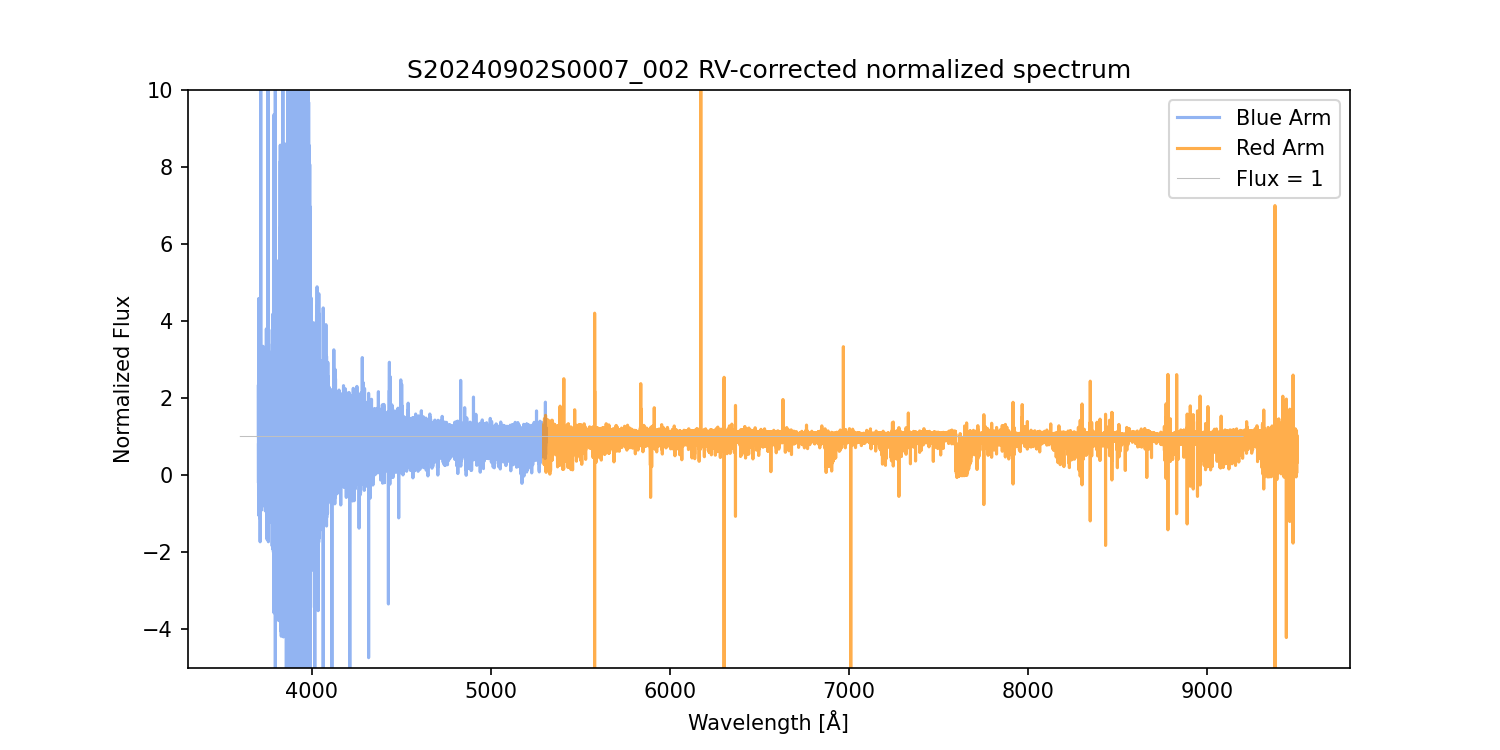

In [28]:
datab = np.genfromtxt(rvnorm_blue+'.xyz', dtype = None, encoding = None, names = True)
datar = np.genfromtxt(rvnorm_red +'.xyz', dtype = None, encoding = None, names = True)

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax.set_ylim(-5,10)
ax.set_title(f'{star}{num} RV-corrected normalized spectrum')
ax.set_ylabel('Normalized Flux')
ax.set_xlabel('Wavelength [Å]')

ax.plot(datab['wavelength'], datab['flux'], c='cornflowerblue' , alpha= 0.7, label='Blue Arm')
ax.plot(datar['wavelength'], datar['flux'], c='darkorange' , alpha= 0.7, label='Red Arm')

x = np.linspace(3600,9200,10000)
ax.plot(x,x*0+1,c="silver",linewidth=0.5, label='Flux = 1')

ax.legend()

# Combining blue and red arms, also combining multiple epochs:

If there are multiple epochs of observations (i.e. over the same, or multiple nights) for a single star, ensure that **each observation has been individually radial velocity corrected** before combining each observation and arm.

In the directory containing all of the radial velocity corrected xyz files **for a single star** (with file suffix `normrv.xyz`), run the commands:

`ls *normrv.xyz > xyz.txt`

`cp xyz.txt fits.txt`

`sed -i 's/xyz/fits/g' fits.txt`

`vim combspec.txt` and input the name of the final output file, e.g. `star_name_normrv.fits`

**xyz.txt** should contain the names of all of the spectra you wish to median-combine. **fits.txt** is the same, just with a `.fits` extension. Make sure that these do not contain spectra from more than one star.

### (May also do `cl`, and then run the `epar` commands there, instead of `pyraf`)

In `pyraf`, run:

`epar rspectext` 

    input = @xyz.txt, output = @fits.txt, (flux) flux calibrated = No, (dtype) = interp
    
All other settings are default, click `Execute`

`epar scombine`

    input = @fits.txt, output = @combspec.txt, (group) = apertures, (combine) = median, (reject) = none
    
All other settings are default, click `Execute`

Now you should have a continuum subtracted, RV-normalized spectrum spanning both the blue and red arms.

# Combining arms, auto-file management steps:

In [33]:
print(fipath)
print(path)

fipath = "/astro/adovgal/SCRIPTS/GHOULS_FIXER_v3/TEST_DATA/Aqu2_776_B/"

star_id = 'Aqu2_776_B'

# ================= File Management ====================
os.system(f'ls {fipath}*normrv.xyz > {fipath}xyz.txt')
os.system(f'cp {fipath}xyz.txt {fipath}fits.txt')
os.system(f"sed -i 's/xyz/fits/g' {fipath}fits.txt")
os.system(f'echo {star_id}_normrv.fits > {fipath}combspec.txt')

##  Optionally, change directories. Note, will need to change back 
##    to FIXER directory to re-run this notebook

# os.chdir(fipath)
# os.system(f'ls *normrv.xyz > xyz.txt')
# os.system(f'cp xyz.txt fits.txt')
# os.system(f"sed -i 's/xyz/fits/g' fits.txt")
# os.system(f'echo {star_id}_normrv.fits > combspec.txt')

/astro/adovgal/SCRIPTS/GHOULS_FIXER_v3/TEST_DATA/Aqu2_776_B/
/astro/adovgal/SCRIPTS/GHOULS_FIXER_v3/


0

# To flatten the final combined fits file to a 1D spectrum (.xy/.xyz):

In [ ]:
Path = '/your_path_to_data/'
obj  = 'STAR_NAME'
fullpath = Path + obj + '/'

File = fullpath + obj + '_normrv.fits'

ftyp = 'cfits'
w, f = sa.read_spec(File, ftype = ftyp)
#w,f,e = sa.read_spec(File, ftype = ftyp)

w_min = 3700
w_max = 9500
ind = np.where( (w >= w_min) & (w <= w_max ) )[0]
wave = w[ind]
flux = np.array(f[ind].flatten(), dtype='float32')
#error = np.array(e[ind].flatten(), dtype='float32')

In [ ]:
save_path = fullpath + obj +'_normrv'
sa.write2xy(wave, flux, save_path)
#sa.write2xyz(wave, flux, error, save_path)